Pujol Romain

Matricule 2343161

# LAB2
### Exercice 1

In [1]:
using Pkg
Pkg.activate(".") #Accède au fichier Project.toml
Pkg.instantiate()
Pkg.status()

using ADNLPModels, LinearAlgebra, NLPModels, Printf

f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1) # fonction objectif vue en classe
g(x) = 6 * [x[1]^2 - x[1] - 2*x[1]*x[2] + x[2]^2 + x[2]; -x[1]^2 + 2*x[1]*x[2] + x[1]] # le gradient de f
H(x) = 6 * [2*x[1]-1-2*x[2] -2*x[1]+2*x[2]+1; -2*x[1]+2*x[2]+1 2*x[1]] # la Hessienne de f

  Activating project at `c:\Users\romai\POLYMTL\MTH8408-Hiv24\lab2`

Status `C:\Users\romai\POLYMTL\MTH8408-Hiv24\lab2\Project.toml`
  [54578032] ADNLPModels v0.7.0
  [7073ff75] IJulia v1.24.2
  [40e66cde] LDLFactorizations v0.10.1
  [a4795742] NLPModels v0.20.0
  [5049e819] OptimizationProblems v0.7.3
⌃ [91a5bcdd] Plots v1.39.0
  [37e2e46d] LinearAlgebra
  [de0858da] Printf
  [8dfed614] Test
Info Packages marked with ⌃ have new versions available and may be upgradable.

H (generic function with 1 method)

In [2]:
function armijo(xk, dk, fk, gk, f)
    slope = dot(gk, dk) #doit être <0
    t = 1.0
    while f(xk + t * dk) > fk + 1.0e-4 * t * slope
      t /= 1.5
    end
    return t
  end

armijo (generic function with 1 method)

In [3]:
#Test pour vérifier que la fonction armijo fonctionne correctement.
using Test #le package Test définit (entre autre) la macro @test qui permet de faire des tests unitaires :-)
xk = ones(2)
gk = g(xk)
dk = - gk
fk = f(xk)
t  = armijo(xk, dk, fk, gk, f)
@test t < 1
@test f(xk + t * dk) <= fk + 1.0e-4 * t * dot(gk,dk)

xk = [1.5, 0.5]
fk = f(xk)
gk = g(xk)
dk = - gk
t  = armijo(xk, dk, fk, gk, f)
@test t < 1
@test f(xk + t * dk) <= f(xk) + 1.0e-4 * t * dot(g(xk),dk)

Test Passed

In [4]:
"""
newton_armijo est une fonction qui va optimiser une fonction sans contrainte avec la méthode de recherche linéaire d'Armijo.
"""

function newton_armijo(nlp, x0; verbose::Bool = true)
    xk  = x0
    fk  = obj(nlp,xk)
    gk = grad(nlp,xk)
    gnorm = gnorm0 = norm(gk)
    k = 0
    verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
    verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
    t0 = time()
    t1=0
    while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15 && neval_obj(nlp)<1000 && t1 < 60 #rajout de conditions 
      Hk = hess(nlp,xk)
      dk = - Hk \ gk
      slope = dot(dk, gk)
      λ = 0.0
      i = 0 #compteur de la deuxième boucle while      
      while slope ≥ -1.0e-4 * norm(dk) * gnorm && i ≤ 5
        λ = max(1.0e-3, 10 * λ)
        dk = - ((Hk + λ * I ) \ gk)
        slope = dot(dk, gk)
        i = i + 1
        if (i==6)
            dk = -gk
            # on sort de la boucle car i>5.
        end
      end
      t = armijo(xk, dk, fk, gk, f)
      xk += t * dk
      fk = f(xk)
      gk = g(xk)
      gnorm = norm(gk)
      k += 1
      verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
      k==1&&print("premier gap : ")
      k==1&&println(xk-x0)
      t1=time()-t0
    end
    
    if (k > 100)
        println("trop d'itérations")
        return 0
    elseif (fk≤-1e15)
        println("problème non borné")
        return 0
    elseif (neval_obj(nlp)≥1000)
        println("trop d'évaluation de la fonction objectif")
        return 0
    elseif (t1≥60)
        println("trop long en temps")
        return 0
    else #si l'on n'est pas dans tous les cas précédents, on est alors très proches d'un zéro du gradient !
        return xk
    end

  end

#Test

f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
x0 = [.5, .5]
nlp = ADNLPModel(f, x0)

newton_armijo(nlp, x0)

 k        fk ||∇f(x)||


 0  1.00e+00   4.5e+00
 1  5.08e-02   8.4e-01 1.0e+00 
premier gap : 

[-0.375, -0.375]
 2  4.73e-04   7.6e-02 1.0e+00 
 3  6.97e-08   9.1e-04 1.0e+00 
 4  1.62e-15   1.4e-07 1.0e+00 


2-element Vector{Float64}:
 2.323057366509693e-8
 2.3230573665124037e-8

On converge vers $[0,0]$ qui est effectivement un point de minimum local, on s'en convainc par le calcul. Le gradient vaut $[0,0]$ et la hessienne vaut : $[-6,6;6,0]$ donc symétrique (diagonalisable et à valeurs propres positives : théorème spectral) et inversible (0 n'est pas valeur propre), donc hessienne en $(0,0)$ définie positive.

### Exercice 2


On va coder une variante de la méthode précédente en utilisant la factorisation $LDL^t$ de la hessienne de la fonction objectif.

In [5]:
using LDLFactorizations, LinearAlgebra

"""
Optimisation sans contrainte que l'on réalise grâce à la factorisation LDLt de la hessienne.
"""
function newton_ldlt_armijo(nlp, x0; verbose::Bool = true)
    xk  = x0
    fk  = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = gnorm0 = norm(gk)
    k = 0
    verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
    verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
    while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15
      Hk = Symmetric(triu(hess(nlp, xk)), :U)
      Sk= ldl_analyze(Hk)
      ldl_factorize!(Hk,Sk)
      if minimum(Sk.d) ≤ 0 #si la matrice n'est pas définie positive
        Sk.d = abs.(Sk.d)
      end
      dk = - Sk \ gk
      slope = dot(dk, gk)
      t = armijo(xk, dk, fk, gk, x -> obj(nlp, x))
      xk += t * dk
      fk = obj(nlp, xk)
      gk = grad(nlp, xk)
      gnorm = norm(gk)
      k += 1
      verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
    end
    return xk
  end

newton_ldlt_armijo

In [6]:
#Test
f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
nlp = ADNLPModel(f, zeros(2))
x0=[.5,.5]
newton_ldlt_armijo(nlp, x0)

 k        fk ||∇f(x)||
 0  1.00e+00   4.5e+00


 1  5.08e-02   8.4e-01 1.0e+00 
 2  4.73e-04   7.6e-02 1.0e+00 
 3  6.97e-08   9.1e-04 1.0e+00 
 4  1.62e-15   1.4e-07 1.0e+00 


2-element Vector{Float64}:
 2.323057366856638e-8
 2.3230573665124037e-8

### Exercice 3

On n'a pas toujours accès à la hessienne de la fonction objectif (et c'est souvent coûteux de l'évaluer : $n^2$ coeffients pour un problème de taille $n$).On va approximer la hessienne grâce à la méthode quasi-Newton BFGS qui permet d'optimiser une fonction en approximant la hessienne.

In [7]:
using LinearAlgebra
"""
optimisation sans contrainte avec approximation de la hessienne, méthode quasi-newton BFGS
"""
function bfgs_quasi_newton_armijo(nlp, x0; verbose::Bool = true)
    xk = x0
    n=first(size(x0)) #utile pour définir les matrices/vecteurs
    sk = zeros(n)
    fk  = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = gnorm0 = norm(gk)
    #il faut faire la première itération à la main car elle est différente des autres
    Hk = I(n)
    k = 0
    dk= -Hk*gk
    t = armijo(xk, dk, fk, gk, x -> obj(nlp, x))
    xk += t*dk
    last2_x=[xk,x0] #on va garder les deux derniers valeurs de xk
    last2_gx=[grad(nlp, xk),grad(nlp, x0)] #on va garder les deux derniers valeurs de ∇xk
    sk=last2_x[1]-last2_x[2]
    yk=last2_gx[1]-last2_gx[2]
    Hk= (transpose(yk)*sk)*I(n)/(transpose(yk)*yk)#on met à jour H0 avant de calculer H1
    fk  = obj(nlp, xk) #il faut réactualiser à la bonne valeur (la valeur pour k=1)
    gk = grad(nlp, xk) #il faut réactualiser à la bonne valeur (la valeur pour k=1)
    gnorm=norm(gk) #il faut réactualiser à la bonne valeur (la valeur pour k=1)
    k=1
    verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
    verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
    while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15
      sk=last2_x[1]-last2_x[2]
      yk=last2_gx[1]-last2_gx[2]
      ρk=1/(transpose(yk)*sk)
      if (ρk>0) #en effet, ρk > 0 indique que le numérateur : transpose(yk)*sk est positif.
        Hk=(I(n)-ρk*(yk*transpose(sk)))*Hk*(I(n)-ρk*(yk*transpose(sk)))+ρk*sk*transpose(sk)
      end
      dk = -Hk*gk
      slope = dot(dk, gk)
      t = armijo(xk, dk, fk, gk, x -> obj(nlp, x))
      xk += t * dk
      fk = obj(nlp, xk)
      gk = grad(nlp, xk)
      gnorm = norm(gk)
      last2_x=[xk,last2_x[1]]
      last2_gx=[gk,last2_gx[1]]
      verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
      k += 1
    end
    return xk
  end

bfgs_quasi_newton_armijo

In [8]:
#Test
x0=[.2, .2]
f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
nlp = ADNLPModel(f, zeros(2))

bfgs_quasi_newton_armijo(nlp, x0)

 k        fk ||∇f(x)||
 1 -1.40e-01   8.9e-01
 1 -3.79e-01   1.4e+00 1.0e+00 
 2 -5.84e-01   3.0e+00 6.7e-01 
 3 -7.55e-01   2.1e+00 2.0e-01 
 4 -9.54e-01   1.2e+00 1.0e+00 
 5 -9.84e-01   6.7e-01 1.0e+00 
 6 -1.00e+00   6.2e-02 1.0e+00 
 7 -1.00e+00   6.8e-02 4.4e-01 
 8 -1.00e+00   2.0e-02 1.0e+00 
 9 -1.00e+00   4.4e-03 1.0e+00 
10 -1.00e+00   4.3e-03 1.0e+00 
11 -1.00e+00   3.0e-05 1.0e+00 
12 -1.00e+00   3.7e-06 1.0e+00 


2-element Vector{Float64}:
 0.9999999992841027
 3.7120831673152225e-9

13 -1.00e+00   5.6e-08 1.0e+00 


On semble converger vers (1,0), effectivement, c'est un point stationnaire avec Hessien =[6 -6; -6 6] (définie positive). En revanche, on n'aterrit pas au même point qu'avec les méthodes précédentes. C'est probablement dû à la première itération qui se base sur la matrice identité, pour la méthode newton armijo le premier gap est (-0.375,-0.375) alors que pour la méthode BFGS c'est (0,-1). Ca se joue probablement à ce niveau-là.

### Exercice 4

In [9]:
using ADNLPModels, OptimizationProblems.ADNLPProblems
using OptimizationProblems
n = 1000
model = genrose(n=n)
@test typeof(model) <: ADNLPModel

Test Passed

In [10]:
x0=(5/6)*ones(n)
newton_ldlt_armijo(model,x0)

 k        fk ||∇f(x)||


 0  1.96e+03   6.0e+02
 1  5.71e+02   5.5e+02 4.4e-01 


 2  1.37e+01   7.3e+01 1.0e+00 


 3  1.02e+00   2.8e+00 1.0e+00 


 4  1.00e+00   1.2e-01 1.0e+00 
 5  1.00e+00   4.1e-02 1.0e+00 


 6  1.00e+00   6.0e-05 1.0e+00 


1000-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0000000409197847
 1.0000000821032848
 1.0000001647179537
 1.000000330390365
 1.0000006624069735
 1.0000013269115509
 1.0000026533254833
 1.0000052866372333
 1.0000104567252532

On peut aussi essayer de résoudre un autre problème.


In [11]:
n=1000
model2=tridia(n=n)
@test unconstrained(model2)

Test Passed

In [12]:
x0= ones(n)
newton_ldlt_armijo(model2,x0)

 k        fk ||∇f(x)||
 0  5.00e+05   3.7e+04


 1  1.86e-26   1.1e-11 1.0e+00 


1000-element Vector{Float64}:
 0.9999999999999996
 0.49999999999999967
 0.24999999999999978
 0.12499999999999978
 0.06249999999999978
 0.031249999999999778
 0.015624999999999778
 0.007812499999999889
 0.00390625
 0.001953124999999889
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Les deux problèmes convergent rapidement (en nombre d'itérations), l'un vers un vecteur rempli de 1, et pour le deuxième vecteur le vecteur : $v=(\frac{1}{2^i})_{i\in[1,n]}$ où $n$ est la taille du problème. Cette méthode peut permettre à l'utilisateur de voir la plus petite puissance de 2 représentable par la machine. En revanche, le temps de calcul augmente très rapidement avec la taille du problème (pour mon ordinateur). On notera aussi que la méthode $LDL^T$ est celle qui marche le mieux, moins d'itération, converge souvent.

### Exercice 5 (premier du devoir) :
On va simplement rendre moins coûteuse la recherche linéaire en calculant directement le paramètre "alpha" sans passer par la fonction armijo et sans utiliser les fonctions de différentiation automatique par exemple.

In [13]:
"""
Méthode BFGS que l'on a codé précédemment dans le cas quadratique, on prendra en entrée la matrice A et le vecteur b de la forme quadratique.
"""
function bfgs_quasi_newton_quadratic(A,b,x0,n; verbose::Bool = true)
    xk = x0
    sk = zeros(n)
    fk  = 0.5*transpose(xk)*A*xk-transpose(b)*xk
    gk = A*xk-b
    gnorm = gnorm0 = norm(gk)
    #il faut faire la première itération à la main car elle est différente des autres
    Hk = I(n)
    k = 0
    dk= -Hk*gk
    t = - transpose(gk)*dk/(transpose(dk)*A*dk)
    xk += t*dk
    last2_x=[xk,x0] #on va garder les deux derniers valeurs de xk
    last2_gx=[A*xk-b,A*x0-b] #on va garder les deux derniers valeurs de ∇xk
    sk=last2_x[1]-last2_x[2]
    yk=last2_gx[1]-last2_gx[2]
    Hk= (transpose(yk)*sk)*I(n)/(transpose(yk)*yk)#on met à jour H0 avant de calculer H1
    fk  = 0.5*transpose(xk)*A*xk-transpose(b)*xk #il faut réactualiser à la bonne valeur (la valeur pour k=1)
    gk = A*xk-b #il faut réactualiser à la bonne valeur (la valeur pour k=1)
    gnorm=norm(gk) #il faut réactualiser à la bonne valeur (la valeur pour k=1)
    k=1
    verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
    verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
    while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15
      sk=last2_x[1]-last2_x[2]
      yk=last2_gx[1]-last2_gx[2]
      ρk=1/(transpose(yk)*sk)
      if (ρk>0) #en effet, ρk > 0 indique que le numérateur : transpose(yk)*sk est positif.
        Hk=(I(n)-ρk*(yk*transpose(sk)))*Hk*(I(n)-ρk*(yk*transpose(sk)))+ρk*sk*transpose(sk)
      end
      dk = -Hk*gk
      slope = dot(dk, gk)
      t = - transpose(gk)*dk/(transpose(dk)*A*dk)
      xk += t * dk
      fk  = 0.5*transpose(xk)*A*xk-transpose(b)*xk
      gk = A*xk-b
      gnorm = norm(gk)
      last2_x=[xk,last2_x[1]]
      last2_gx=[gk,last2_gx[1]]
      verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
      k += 1
    end
    return xk
  end

bfgs_quasi_newton_quadratic

In [14]:
#Test
n = 10
A = diagm(-1 => ones(n-1), 0 => 4*ones(n), 1 => ones(n-1))
b = A * [1:n;]
x0=zeros(n)
x = bfgs_quasi_newton_quadratic(A,b,x0,n)

 k        fk ||∇f(x)||
 1 -1.09e+03   6.6e+00
 1 -1.10e+03   1.5e+00 1.3e+00 
 2 -1.10e+03   5.1e-01 1.4e+00 
 3 -1.10e+03   2.0e-01 1.1e+00 
 4 -1.10e+03   9.2e-02 1.1e+00 
 5 -1.10e+03   4.1e-02 9.8e-01 
 6 -1.10e+03   2.0e-02 9.7e-01 
 7 -1.10e+03   9.3e-03 9.4e-01 
 8 -1.10e+03   4.5e-03 9.3e-01 
 9 -1.10e+03   2.2e-03 9.2e-01 
10 -1.10e+03   1.1e-03 9.2e-01 
11 -1.10e+03   5.3e-04 9.2e-01 
12 -1.10e+03   2.6e-04 9.2e-01 
13 -1.10e+03   1.3e-04 9.3e-01 
14 -1.10e+03   6.3e-05 9.3e-01 


10-element Vector{Float64}:
 1.0000027012408943
 1.9999968406027375
 3.0000111765049393
 3.9999911098686174
 5.000014202491427
 5.9999992342914625
 7.000000207373806
 8.000004091132123
 9.00000082463392
 9.999998681165296

$\alpha$ est toujours bien défini théoriquement car A est symétrique définie positive (donc $\forall d, d^TAd \geq 0$).

### Exercice 6
On va étudier les vitesses de convergences des différentes méthodes pour la fonction d'Himmelbau en partant du même point.

Pour étudier les erreurs, il faut avoir accès à tous les $x_k$ après avoir réussi à trouver l'optimum, je vais donc modifier chacune des fonctions faites jusqu'à présent pour renvoyer plutôt l'ensemble des $x_k$. $V_k=[x_0,x_1,...,x_k]$ 

In [15]:
function newton_armijo_graph(nlp, x0; verbose::Bool = true)
    xk  = x0
    Vk= x0
    fk  = obj(nlp,xk)
    gk = grad(nlp,xk)
    gnorm = gnorm0 = norm(gk)
    k = 0
    verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
    verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
    t0 = time()
    t1=0
    while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && t1<60
      Hk = hess(nlp,xk)
      dk = - Hk \ gk
      slope = dot(dk, gk)
      λ = 0.0
      i = 0 #compteur de la deuxième boucle while      
      while slope ≥ -1.0e-4 * norm(dk) * gnorm && i ≤ 5
        λ = max(1.0e-3, 10 * λ)
        dk = - ((Hk + λ * I ) \ gk)
        slope = dot(dk, gk)
        i = i + 1
        if (i==6)
            dk = -gk
            # pas besoin de mettre slope=0 pour sortir de la boucle, on sort de la boucle car i>5.
        end
      end
      t = armijo(xk, dk, fk, gk, f)
      xk += t * dk
      fk = f(xk)
      gk = g(xk)
      gnorm = norm(gk)
      k += 1
      verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
      append!(Vk,xk)
      t1=time()-t0
    end
    return Vk
  end

newton_armijo_graph (generic function with 1 method)

In [16]:
fH(x)=(x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
x0=[3.2,2.8]
himmelbau = ADNLPModel(fH, x0)
#V=newton_armijo_graph(himmelbau,x0)

ADNLPModel - Model with automatic differentiation backend ADModelBackend{
  ForwardDiffADGradient,
  ForwardDiffADHvprod,
  EmptyADbackend,
  EmptyADbackend,
  EmptyADbackend,
  ForwardDiffADHessian,
  EmptyADbackend,
}
  Problem name: Generic
   All variables: ████████████████████ 2      All constraints: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            free: ████████████████████ 2                 free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
         low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0              low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
          infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0               infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            nnzh: (  0.00% sparsity)   3               linear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
                            

Ce premier modèle ne converge pas pour moi. Je ne vais pas tracer de graphe, cela serait impossible (on n'a pas de $x_{final}$ et les résultats seraient incohérents).

In [17]:
"""
on réutilise la fonction newton_ldlt_armijo mais l'on garde chaque valeur de x_k pour tracer un graphe.
"""
function newton_ldlt_armijo_graph(nlp, x0; verbose::Bool = true)
    xk  = x0
    fk  = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = gnorm0 = norm(gk)
    k = 0
    Vk=xk
    while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 50 && fk > -1e15
      Hk = Symmetric(triu(hess(nlp, xk)), :U)
      Sk= ldl_analyze(Hk)
      ldl_factorize!(Hk,Sk)
      if minimum(Sk.d) ≤ 0 #si la matrice n'est pas définie positive
        Sk.d = abs.(Sk.d)
      end
      dk = - Sk \ gk
      slope = dot(dk, gk)
      t = armijo(xk, dk, fk, gk, x -> obj(nlp, x))
      xk += t * dk
      fk = obj(nlp, xk)
      gk = grad(nlp, xk)
      gnorm = norm(gk)
      k += 1
      append!(Vk,xk)
    end
    return Vk
  end

newton_ldlt_armijo_graph

In [18]:
fH(x)=(x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
x0=[20.,10.]
himmelbau = ADNLPModel(fH, x0)
V_ldlt=newton_ldlt_armijo_graph(himmelbau,x0)

18-element Vector{Float64}:
 20.0
 10.0
 13.390370878324479
  6.391671048326206
  9.05078572775179
  4.04739709846835
  6.256886820921224
  2.587111787927074
  4.537307800535773
  1.8030291368151445
  3.5711492586135694
  1.6758782313548235
  3.1089089294799654
  1.9943174819898715
  3.006045622749333
  1.9970322386840371
  3.0000181760074414
  1.9999955362745592

In [19]:
using LinearAlgebra
"""
optimisation sans contrainte avec approximation de la hessienne, méthode quasi-newton BFGS, où l'on garde chaque valeur de x_k pour tracer un graphe.
"""
function bfgs_quasi_newton_armijo_graph(nlp, x0; verbose::Bool = true)
    xk = x0
    Vk=xk
    n=first(size(x0)) #utile pour définir les matrices/vecteurs
    sk = zeros(n)
    fk  = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = gnorm0 = norm(gk)
    #il faut faire la première itération à la main car elle est différente des autres
    Hk = I(n)
    k = 0
    dk= -Hk*gk
    t = armijo(xk, dk, fk, gk, x -> obj(nlp, x))
    xk += t*dk
    last2_x=[xk,x0] #on va garder les deux derniers valeurs de xk
    last2_gx=[grad(nlp, xk),grad(nlp, x0)] #on va garder les deux derniers valeurs de ∇xk
    sk=last2_x[1]-last2_x[2]
    yk=last2_gx[1]-last2_gx[2]
    Hk= (transpose(yk)*sk)*I(n)/(transpose(yk)*yk)#on met à jour H0 avant de calculer H1
    fk  = obj(nlp, xk) #il faut réactualiser à la bonne valeur (la valeur pour k=1)
    gk = grad(nlp, xk) #il faut réactualiser à la bonne valeur (la valeur pour k=1)
    gnorm=norm(gk) #il faut réactualiser à la bonne valeur (la valeur pour k=1)
    k=1
    while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15
      sk=last2_x[1]-last2_x[2]
      yk=last2_gx[1]-last2_gx[2]
      ρk=1/(transpose(yk)*sk)
      if (ρk>0) #en effet, ρk > 0 indique que le numérateur : transpose(yk)*sk est positif.
        Hk=(I(n)-ρk*(yk*transpose(sk)))*Hk*(I(n)-ρk*(yk*transpose(sk)))+ρk*sk*transpose(sk)
      end
      dk = -Hk*gk
      slope = dot(dk, gk)
      t = armijo(xk, dk, fk, gk, x -> obj(nlp, x))
      xk += t * dk
      fk = obj(nlp, xk)
      gk = grad(nlp, xk)
      gnorm = norm(gk)
      last2_x=[xk,last2_x[1]]
      last2_gx=[gk,last2_gx[1]]
      k += 1
      append!(Vk,xk)
    end
    return Vk
  end

bfgs_quasi_newton_armijo_graph

In [20]:
fH(x)=(x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
x0=[3.2,2.8]
himmelbau = ADNLPModel(fH, x0)
V_bfgs=bfgs_quasi_newton_armijo_graph(himmelbau,x0)

26-element Vector{Float64}:
 3.2
 2.8
 2.876728714682797
 2.0943660735682506
 2.9738730053321816
 2.0854536343606482
 2.9771022341978712
 2.048981600091486
 3.0012397501000483
 2.012090603407465
 ⋮
 2.0000359031272765
 2.999985661178915
 2.0000035801978386
 3.000002582994704
 2.0000060198809475
 2.999998866282436
 2.000001137634053
 3.000000149102939
 2.000000610487862

J'ai enlevé les prints : fk, gk, norme de gk pour faciliter la lisibilité.

Représentons les graphes que nous obtenons pour la méthode de factorisation $LDL^T$. Le point positif est qu'on converge vers $[3,2]$ qui est un minimum local.

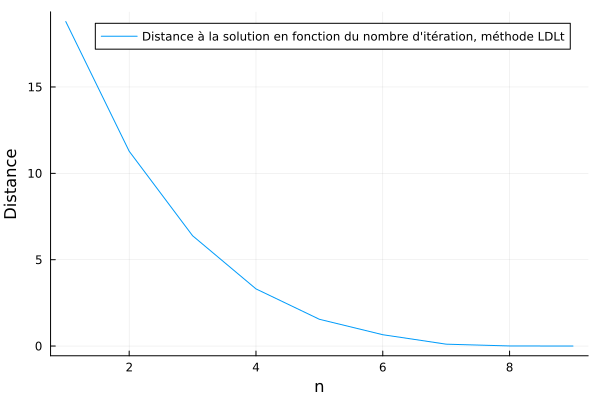

In [21]:
using Plots
taille=length(V_ldlt)
n=taille÷2 #donne le nombre de vecteurs constituant V_ldlt
norme_ldlt=zeros(n)
for i in 1:n
    norme_ldlt[i]=sqrt((V_ldlt[2*i-1]-V_ldlt[taille-1])^2+(V_ldlt[2*i]-V_ldlt[taille])^2)
end
x=range(1,n,n)
plot(x,norme_ldlt, label="Distance à la solution en fonction du nombre d'itération, méthode LDLt",xlabel="n",ylabel="Distance")

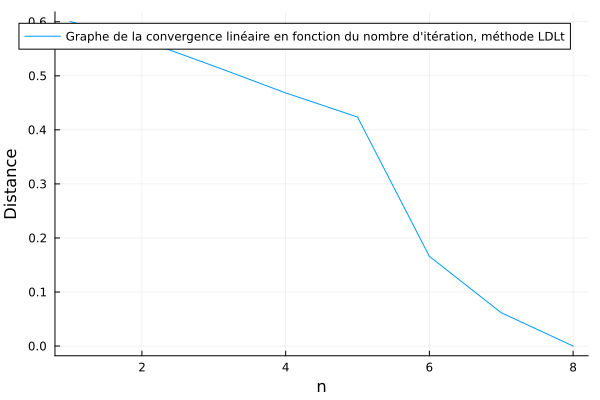

In [22]:
conv_lineaire_ldlt=zeros(n-1)
for i in 1:n-1
    conv_lineaire_ldlt[i]=norme_ldlt[i+1]/norme_ldlt[i]
end
x=range(1,n-1,n-1)
plot(x,conv_lineaire_ldlt, label="Graphe de la convergence linéaire en fonction du nombre d'itération, méthode LDLt",xlabel="n",ylabel="Distance")

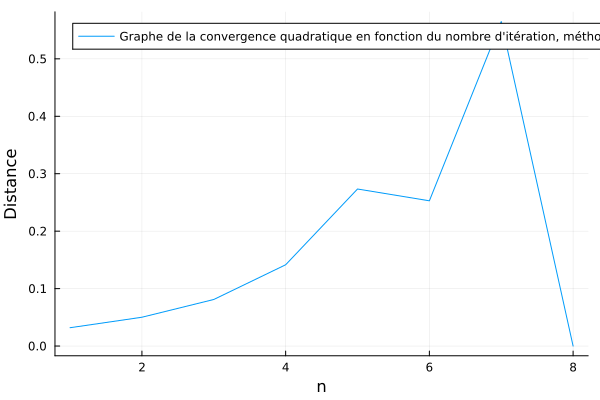

In [23]:
conv_quad_ldlt=zeros(n-1)
for i in 1:n-1
    conv_quad_ldlt[i]=norme_ldlt[i+1]/(norme_ldlt[i]^2)
end
x=range(1,n-1,n-1)
plot(x,conv_quad_ldlt, label="Graphe de la convergence quadratique en fonction du nombre d'itération, méthode LDLt",xlabel="n",ylabel="Distance")

Comme on est dans le cas des méthodes de Newton : on a bien le caractère borné de $\frac{||x_{k+1}-x^*||}{||x_{k}-x^*||^2}\leq C$ où C peut valoir 1 ici. Ce caractère implique que la valeur de la quantité $\frac{||x_{k+1}-x^*||}{||x_{k}-x^*||}$ tend vers 0 ce qui a l'air d'être le cas. 

Pour les deux autres méthodes, on ne converge pas de si loin. La méthode BFGS fonctionne localement (proche d'un minimum) tandis que la méthode Newton Armijo ne converge que très rarement (et avec beaucoup de calcul).

On peut néanmoins représenter les graphes avec la méthode BFGS en partant de $[3.2,2.8]$.

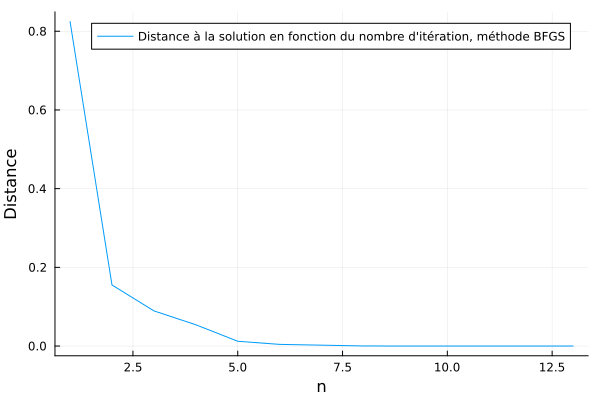

In [28]:
taille=length(V_bfgs)
n=taille÷2 #donne le nombre de vecteurs constituant V_bfgs
norme_bfgs=zeros(n)
for i in 1:n
    norme_bfgs[i]=sqrt((V_bfgs[2*i-1]-V_bfgs[taille-1])^2+(V_bfgs[2*i]-V_bfgs[taille])^2)
end
x=range(1,n)
plot(x,norme_bfgs, label="Distance à la solution en fonction du nombre d'itération, méthode BFGS",xlabel="n",ylabel="Distance")

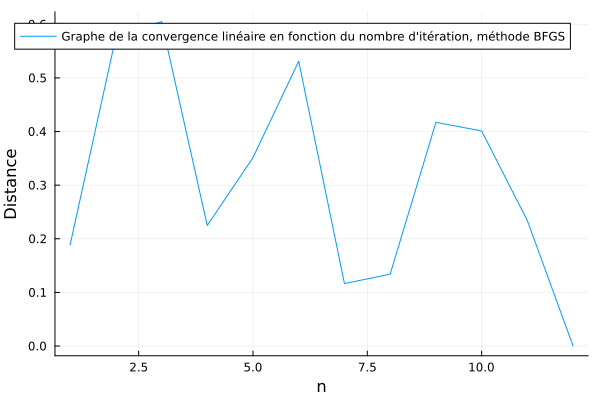

In [29]:
conv_lineaire_bfgs=zeros(n-1)
for i in 1:n-1
    conv_lineaire_bfgs[i]=norme_bfgs[i+1]/norme_bfgs[i]
end
x=range(1,n-1,n-1)
plot(x,conv_lineaire_bfgs, label="Graphe de la convergence linéaire en fonction du nombre d'itération, méthode BFGS",xlabel="n",ylabel="Distance")

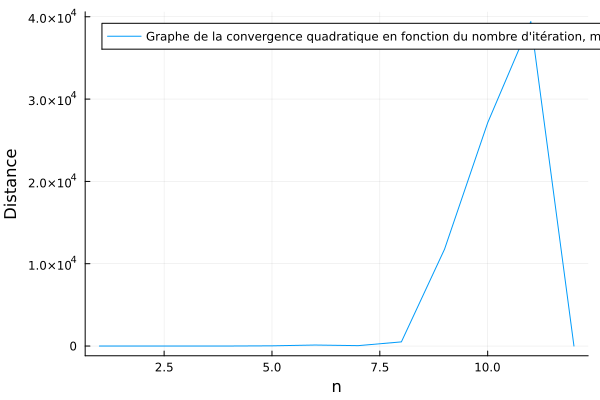

In [30]:
conv_quad_bfgs=zeros(n-1)
for i in 1:n-1
    conv_quad_bfgs[i]=norme_bfgs[i+1]/norme_bfgs[i]^2
end
x=range(1,n-1,n-1)
plot(x,conv_quad_bfgs, label="Graphe de la convergence quadratique en fonction du nombre d'itération, méthode BFGS",xlabel="n",ylabel="Distance")

Pour la méthode BFGS, on a effectivement l'impression que $||x_{k+1}-x^*||=o(x_{k}-x^*)$ : on a l'impression que le graphe tend vers 0. En revanche on n'a pas de résultat pour la convergence quadratique.